In [99]:
import sys
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import numpy as np
import SimpleITK as sitk
import radiomics as rad
import six
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

%load_ext autoreload
%autoreload 2

plt.rcParams.update({"axes.facecolor" : "white",
                     "axes.edgecolor":  "black",
                     "patch.facecolor": "white",
                     "figure.facecolor" : "white"}) # prevent the transparency 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
sys.path.append(os.path.abspath('src/'))
from data.lungdataset import LungData
#from utils import extract_firstlevel_features

In [101]:
rootdir = "/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh1_A"
ld = LungData(rootdir)
medical_df = ld.raw_ehd
ehd = ld.process_features(return_df=True, remove_redundant=True, normalize_dates=False)
#ld.as_dataframe()

print(medical_df.shape, "---", ehd.shape)

(1279, 130) --- (1279, 77)


## Exploration

In [102]:
scaler = StandardScaler()
ehds = pd.DataFrame(scaler.fit_transform(ehd), columns=ehd.columns)

In [103]:
corr_thresh = 0.95
corr_matrix = ehds.corr().abs() # Create correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # Select upper triangle of correlation matrix
to_drop = [column for column in upper.columns if any(upper[column] > corr_thresh)] # Find features with correlation greater than 0.95
print(to_drop)

['gender_concept_name_MALE']


we have lots of binary columns created by pre-processing which will by design go for high (neg.) correlation. We should not drop those. The only one which should be dropped is the Sodium one, which for some reason seems to be in the dataset twice for some reason (even in the raw one). We drop it in the lungdataset now for all future implementations, this is why it is not listed here anymore most likely!

In [104]:
ml_df = ld.ml_target_df # get pretty labels
#ml_df["to_patient_id"] = medical_df["to_patient_id"] # merge pretty labels with patient ids
ehds[ld._targets] = ehd[ld._targets] # overwrite scaled targets
ehds_ml = pd.concat([ehds, pd.get_dummies(ml_df["Outcome"])], axis=1)
targets = ld._targets + list(ehds_ml.columns[-8:])
ehds_ml[targets].head()

last.status        is_icu  was_ventilated  Deceased  Deceased + ICU  \
0          0.0 -2.775558e-17             0.0         0               0   
1          1.0  1.000000e+00             0.0         0               1   
2          1.0  1.000000e+00             1.0         0               0   
3          1.0  1.000000e+00             1.0         0               0   
4          0.0 -2.775558e-17             0.0         0               0   

   Deceased + ICU + Ventilated  Deceased + Ventilated  Hospitalized (only)  \
0                            0                      0                    1   
1                            0                      0                    0   
2                            1                      0                    0   
3                            1                      0                    0   
4                            0                      0                    1   

   ICU  ICU + Vent  Ventilated  
0    0           0           0  
1    0           0           0  
2    0           0           0  
3    0           0           0  
4    0           0           0

In [105]:
tt = ["invasive_vent_days", "length_of_stay", "Acute.Kidney.Injury..during.hospitalization.", "Acute.Hepatic.Injury..during.hospitalization."]

_drops = ld._targets#+tt#+ld._drop_categorical

In [106]:
_ordering = ["Hospitalized (only)", 
    "ICU", "Ventilated", "ICU + Vent",
    "Deceased", "Deceased + ICU", "Deceased + Ventilated", 
    "Deceased + ICU + Ventilated"]
ehds_ml.corr()[targets].iloc[:-8,:].drop(_drops).sort_values(by="Hospitalized (only)", ascending=True)[_ordering]
print("MAX: ", ehds_ml.corr()[targets].iloc[:-8,:].drop(_drops).sort_values(by="Hospitalized (only)", ascending=True)[_ordering].max().max(), 
    "MIN :", ehds_ml.corr()[targets].iloc[:-8,:].drop(_drops).sort_values(by="Hospitalized (only)", ascending=True)[_ordering].min().min())

MAX:  0.4568113230097137 MIN : -0.3193180519324813


In [107]:
cdf = ehds_ml.corr()
shortticks = [c[-15:] for c in cdf.columns]

_rn = { "Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)":
    "Glomerular filtration rate/1.73 in Serum, Plasma or Blood",
    "Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P":
    "Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma",
    'Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count':
     'Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood',
}

heatmap_ehds_mldf = ehds_ml.copy()
heatmap_ehds_mldf = heatmap_ehds_mldf.reindex(sorted(heatmap_ehds_mldf.columns, key=lambda v: v.lower()), axis=1)

_newcols = []
for _c in heatmap_ehds_mldf.columns:
    if "in Serum" in _c:
        _newcols.append(_c.split("in Serum")[0])
    elif "in Blood" in _c:
        _newcols.append(_c.split("in Blood")[0])
    elif "in Platelet" in _c:
        _newcols.append(_c.split("in Platelet")[0])
    elif "in Arterial" in _c:
        _newcols.append(_c.split("in Arterial")[0])
    else:
        _newcols.append(_c)
heatmap_ehds_mldf.columns=_newcols

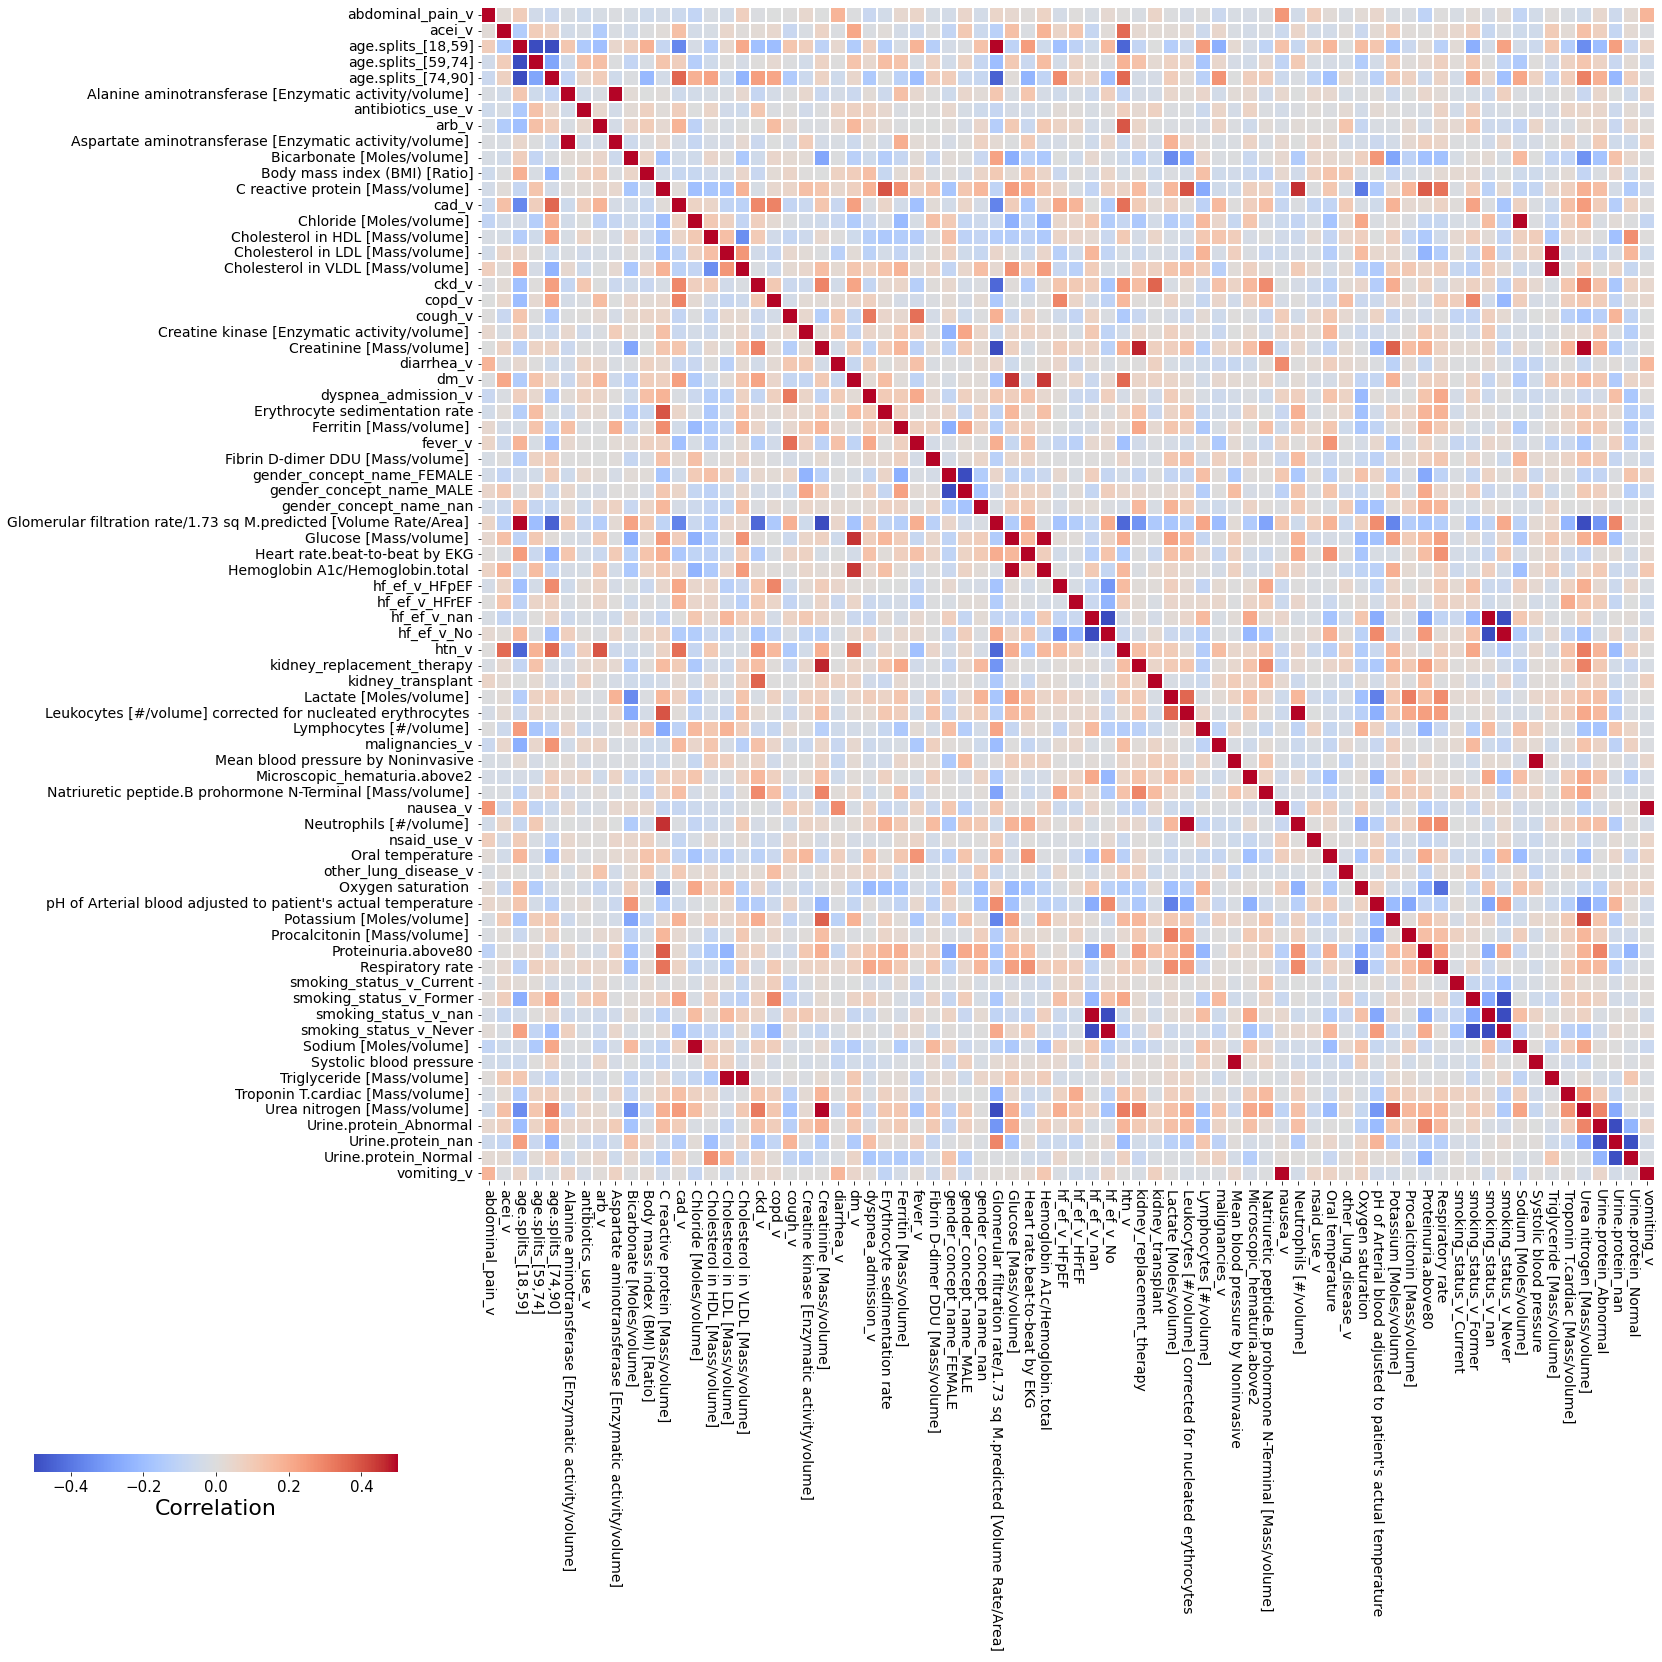

In [108]:
plt.figure(figsize=(23,28))
ax = sns.heatmap(heatmap_ehds_mldf.drop(_drops + _ordering, axis=1).rename(columns=_rn).corr()#.sort_values(by="Hospitalized (only)", ascending=True)
    ,
    square=True,
    vmax=0.5, vmin=-0.5,
    #annot=True,
    #fmt=".1f",
    linewidths=0.01, 
    cmap="coolwarm",
    cbar=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal",
        "location": "bottom",
        "fraction": 0.01,# "aspect":20, #"shrink":0.08,
        "anchor": (-0.55, 5.0)
        },
    #yticklabels=shortticks[:-8]
)
#plt.title("Radiomics Features correlation with prediction targets", size=16)
ax.figure.axes[-1].xaxis.label.set_size(22)
plt.yticks(size=14)
plt.xticks(size=14, rotation=270)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.tight_layout()
#cax.set_position(-0.55, .6)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=10.0)
#plt.subplots_adjust(left=0, bottom=None, right=0, top=None, wspace=None, hspace=None)
plt.savefig("../thesis/figures/impl/corr_heatmap.png",) #dpi=180)
#plt.savefig("../thesis/figures/impl/corr_heatmap_180dpi.png", dpi=180)
#plt.savefig("../thesis/figures/impl/corr_heatmap_320dpi.png", dpi=320)

In [109]:
for k in keepvars:
    print(k,rowsums[k])

acei_v 2
age.splits_[18,59] 2
age.splits_[74,90] 3
Alanine aminotransferase [Enzymatic activity/volume]  2
arb_v 2
Aspartate aminotransferase [Enzymatic activity/volume]  2
C reactive protein [Mass/volume]  5
cad_v 2
Chloride [Moles/volume]  2
Cholesterol in LDL [Mass/volume]  2
Cholesterol in VLDL [Mass/volume]  2
ckd_v 2
Creatinine [Mass/volume]  4
dm_v 4
Erythrocyte sedimentation rate 2
Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area]  2
Glucose [Mass/volume]  3
Hemoglobin A1c/Hemoglobin.total  3
hf_ef_v_nan 2
hf_ef_v_No 2
htn_v 5
kidney_replacement_therapy 2
kidney_transplant 2
Lactate [Moles/volume]  2
Leukocytes [#/volume] corrected for nucleated erythrocytes  4
Mean blood pressure by Noninvasive 2
nausea_v 2
Neutrophils [#/volume]  3
Potassium [Moles/volume]  3
Proteinuria.above80 2
smoking_status_v_nan 2
smoking_status_v_Never 2
Sodium [Moles/volume]  2
Systolic blood pressure 2
Triglyceride [Mass/volume]  3
Urea nitrogen [Mass/volume]  3
vomiting_v 2


37


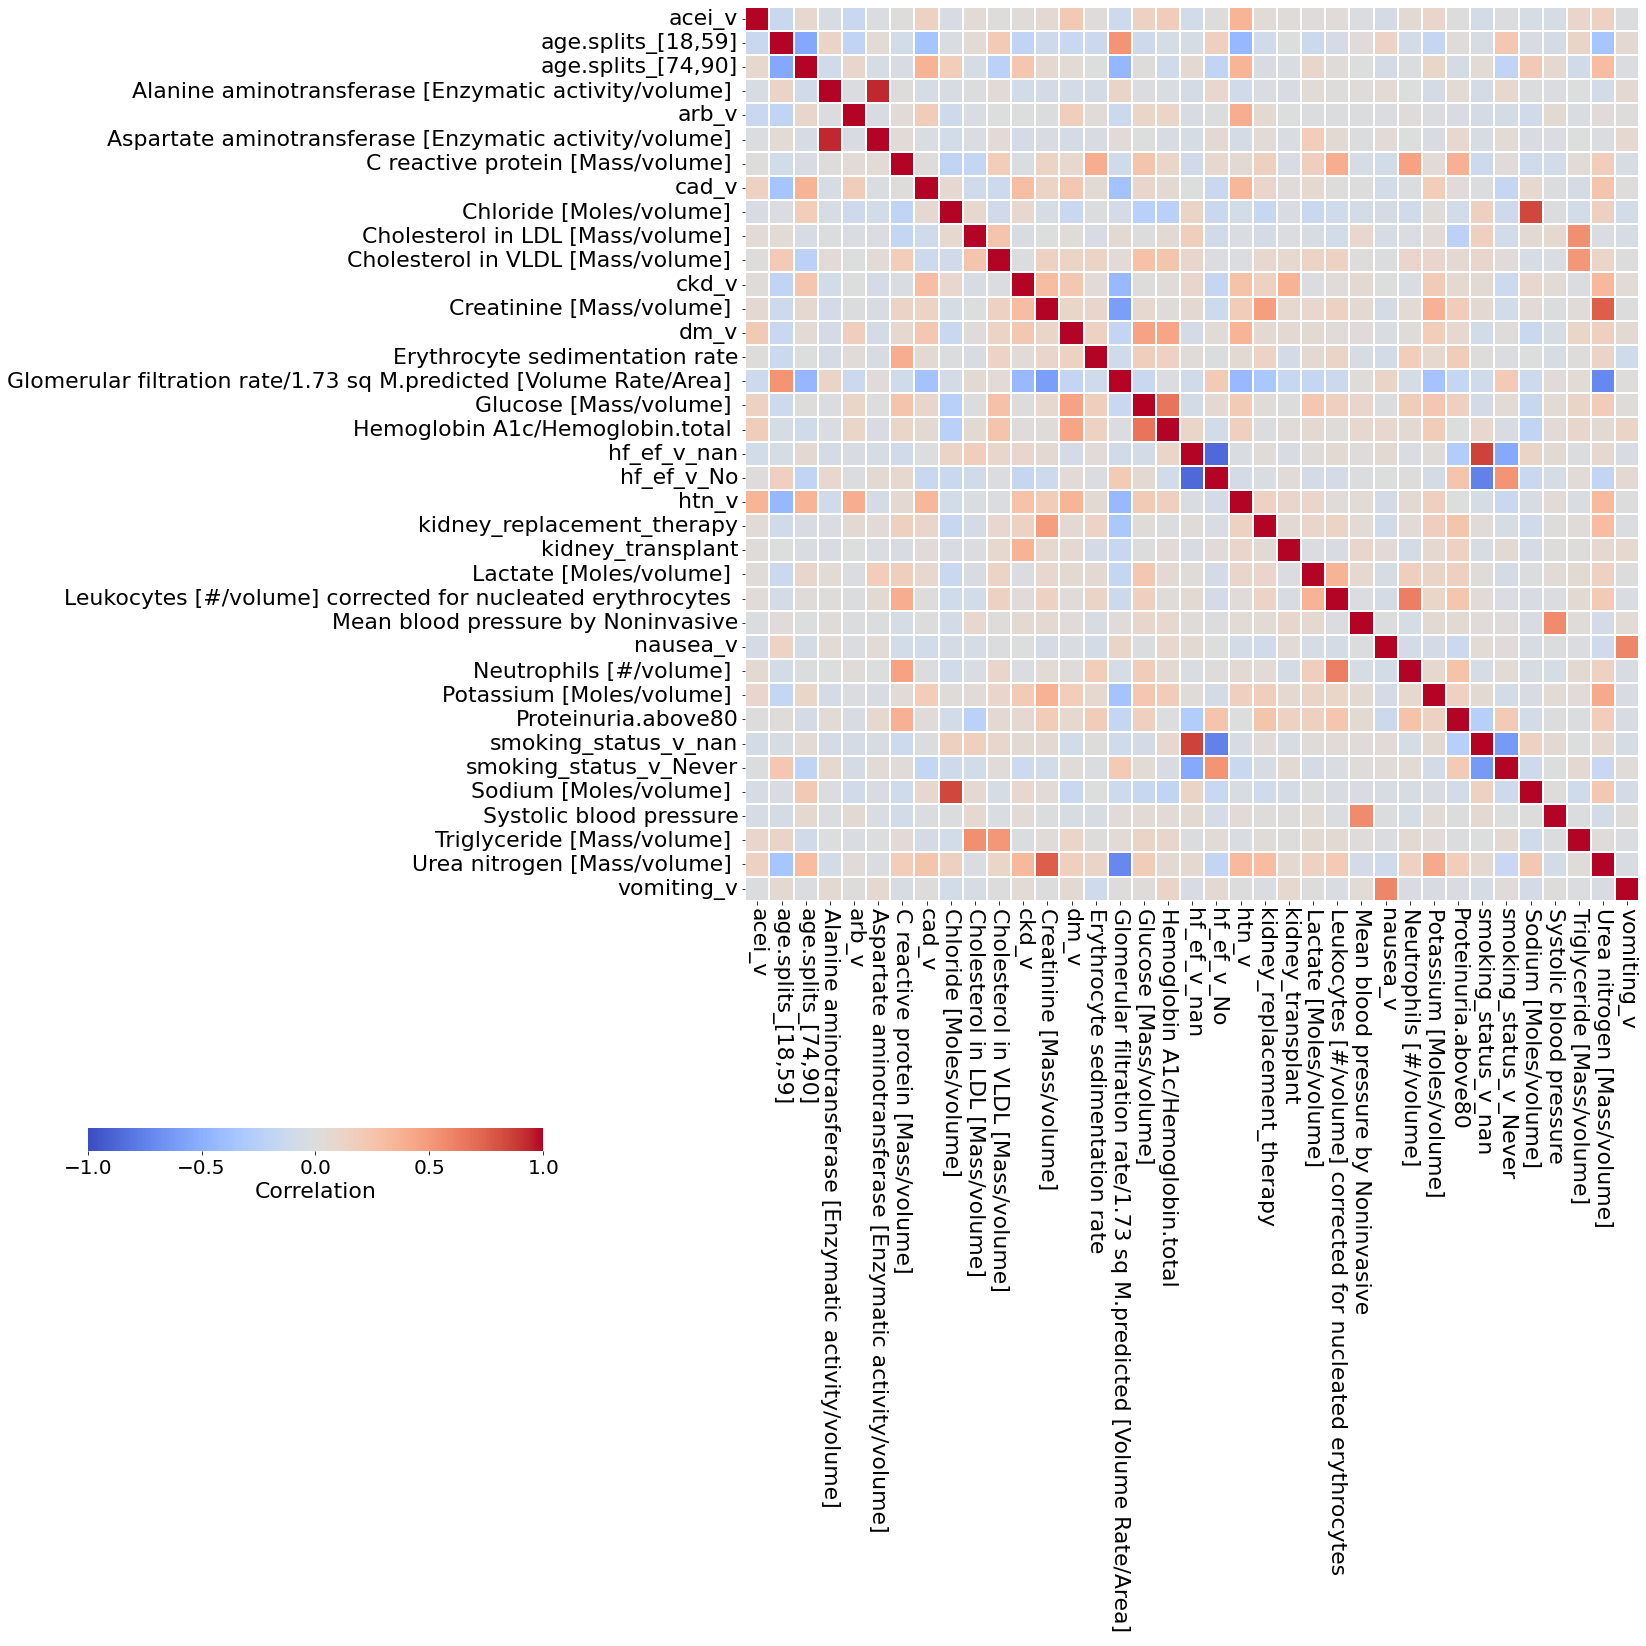

In [110]:
_corrdf = heatmap_ehds_mldf.drop(_drops + _ordering, axis=1).rename(columns=_rn).corr()
thresh = 0.35
booleancdf = _corrdf > thresh
rowsums = dict(booleancdf.astype(int).sum(axis=0))
keepvars = []
for k,v in rowsums.items():
    if v>1: #only keep vars that have more than 1 other var with corr > thresh basically
        keepvars.append(k)
print(len(keepvars))
plt.figure(figsize=(23,28))
ax = sns.heatmap(_corrdf.loc[keepvars,keepvars],
    linewidths=0.1, 
    vmin=-1, vmax=1,
    cmap="coolwarm",
    square=True,
    cbar=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal",
        "location": "bottom",
        "fraction": 0.015,# "aspect":20, #"shrink":0.08,
        "anchor": (-1.5, 8.0)
        },
    #yticklabels=shortticks[:-8]
)
ax.figure.axes[-1].xaxis.label.set_size(22)
plt.yticks(size=22)
plt.xticks(size=22, rotation=270)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=20)
plt.tight_layout()
#cax.set_position(-0.55, .6)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=10.0)
plt.savefig("../thesis/figures/impl/corr_heatmap_thresh035.png",) #dpi=180)


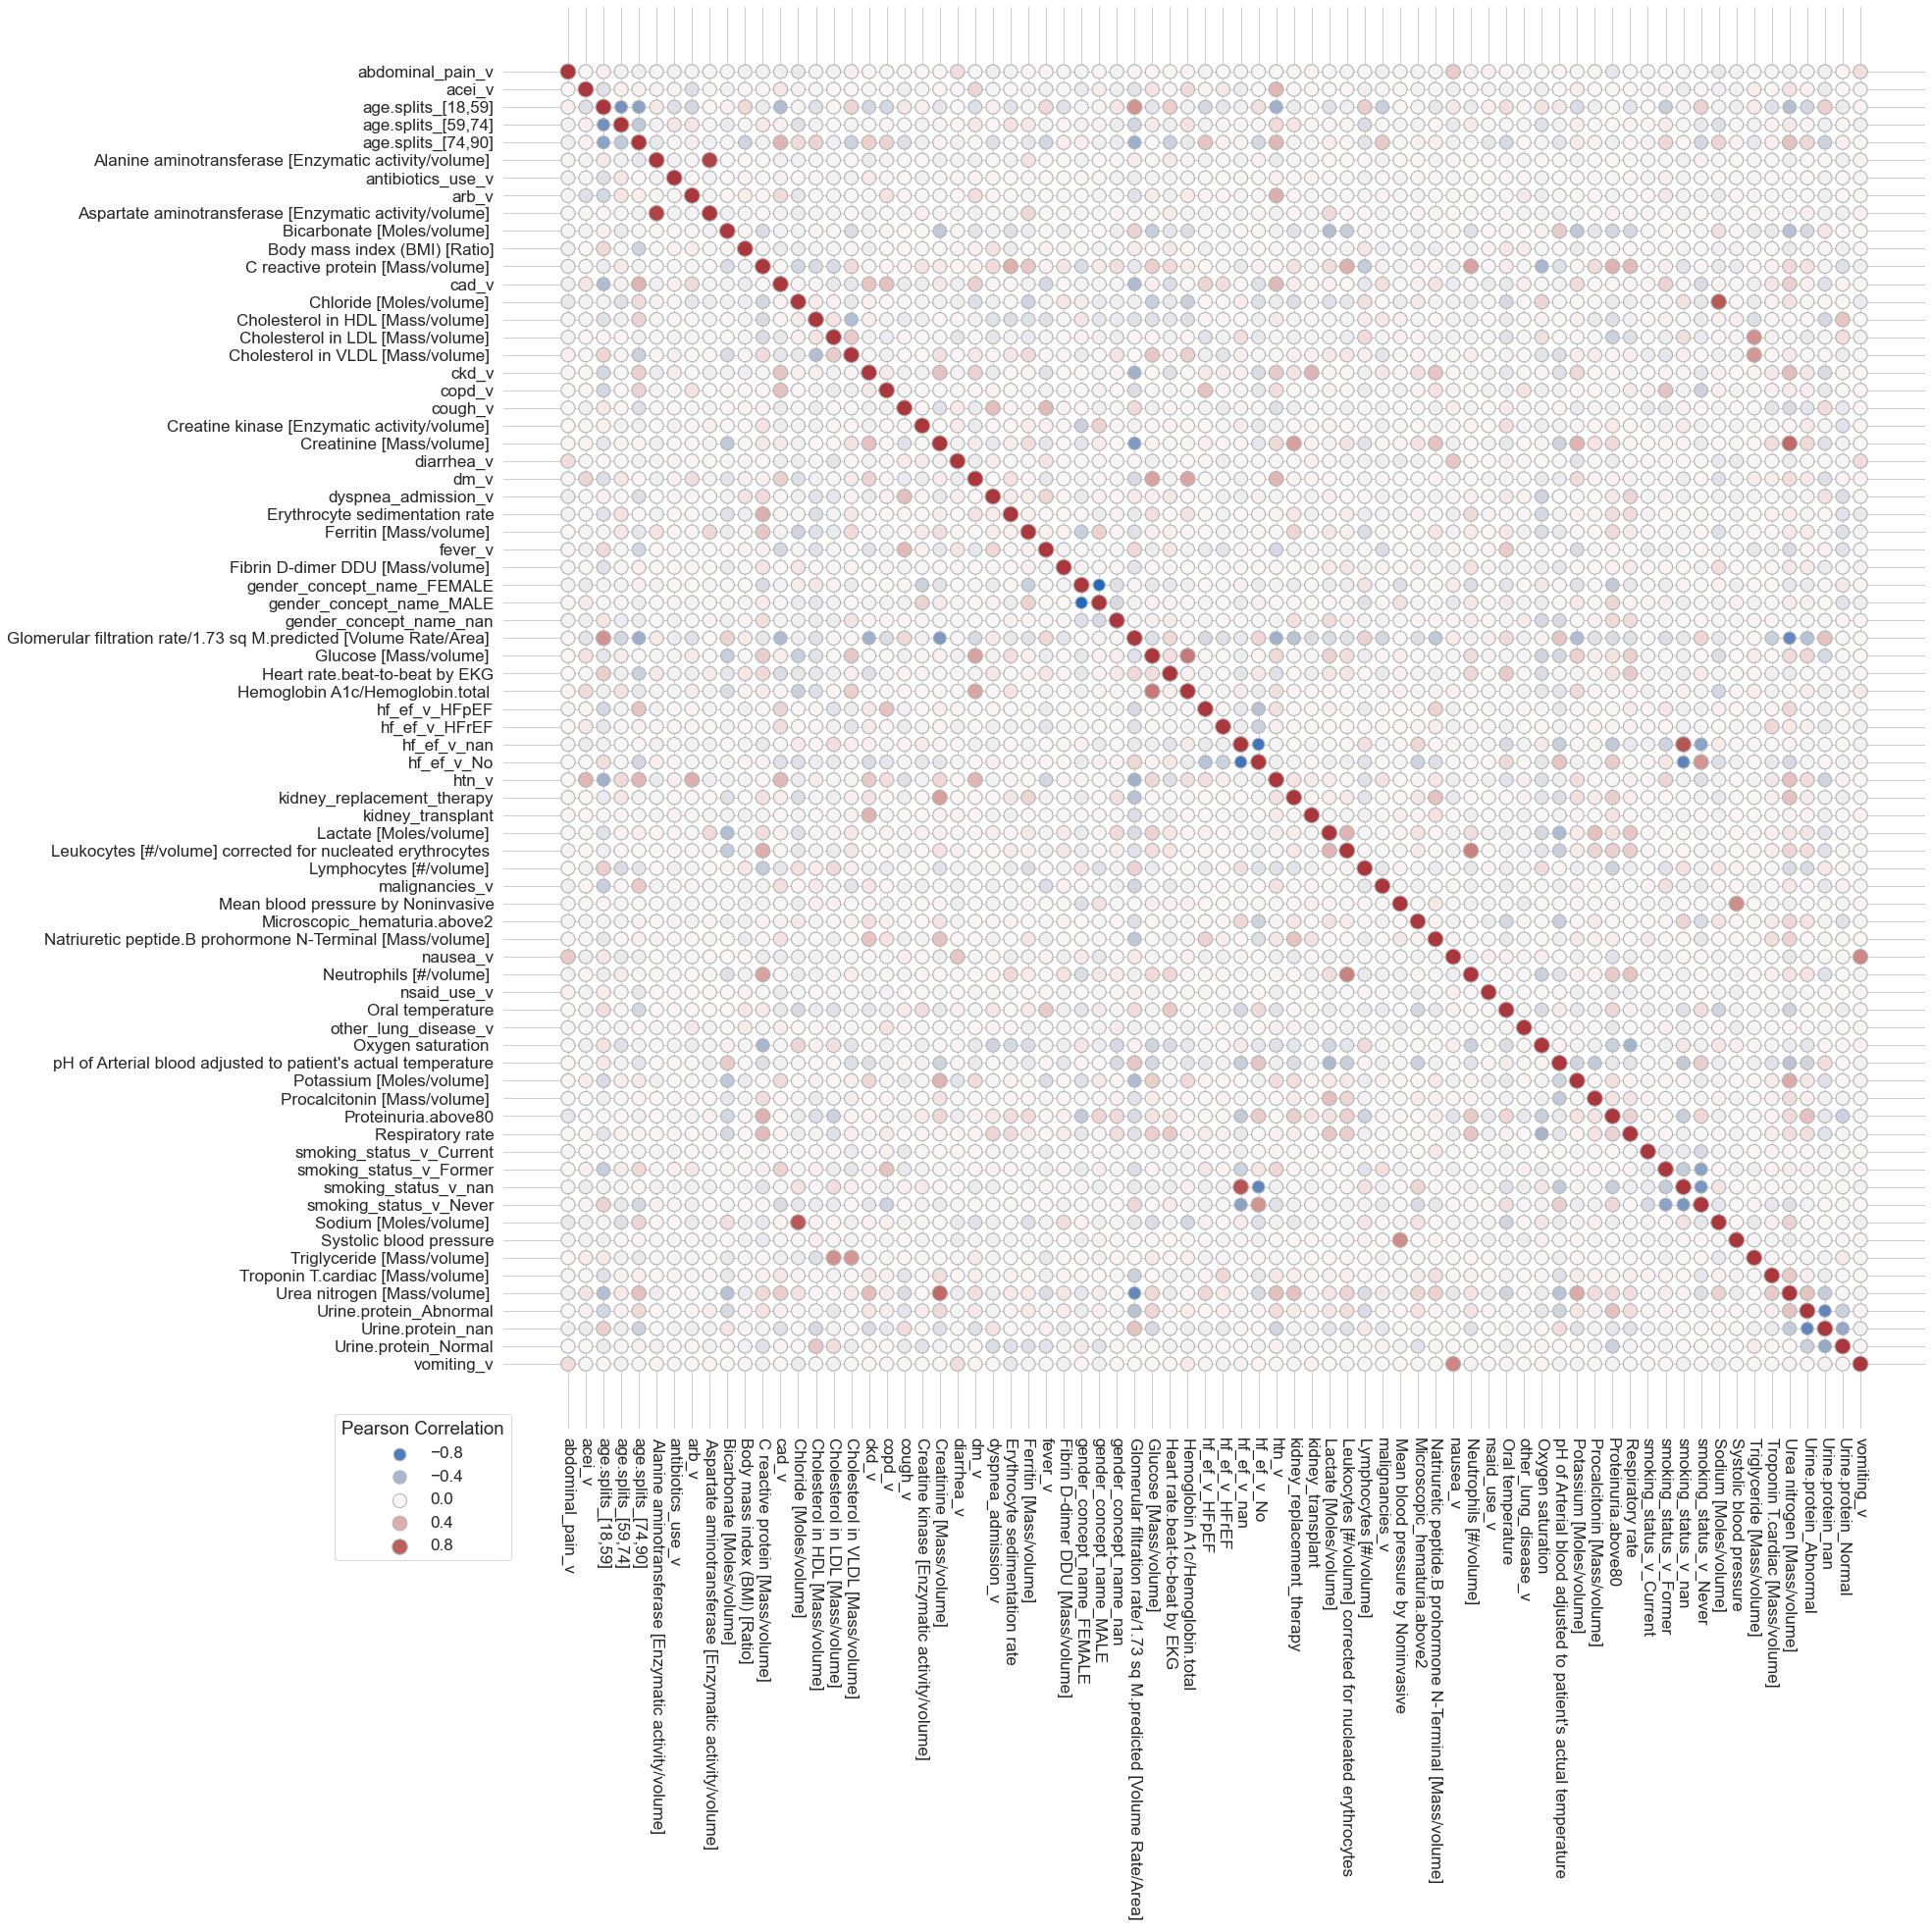

In [111]:
sns.set_theme(style="whitegrid", font_scale=1.55)
g = sns.relplot(
    data=heatmap_ehds_mldf.drop(_drops + _ordering, axis=1).rename(columns=_rn).corr().stack().reset_index(name="correlation"),
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", #hue_norm=(-.5, .5),
    edgecolor=".7",
    height=28, sizes=(150, 250), 
    #size_norm=(-.5, .5),
    #legend="auto",
)
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
for label in g.ax.get_xticklabels():
    label.set_rotation(270)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
g.tight_layout()
leg = g._legend
leg.set_bbox_to_anchor([0.25, 0.225])
leg.set_frame_on(True)
leg.set_title("Pearson Correlation")
#leg._loc = 2
#g.add_legend(title="Cluster", loc="lower left", bbox_to_anchor=(-0.55, .6))
#g.savefig("../thesis/figures/impl/corr_relmap_180dpi.png", dpi=180)
#g.savefig("../thesis/figures/impl/corr_relmap_320dpi.png", dpi=320)

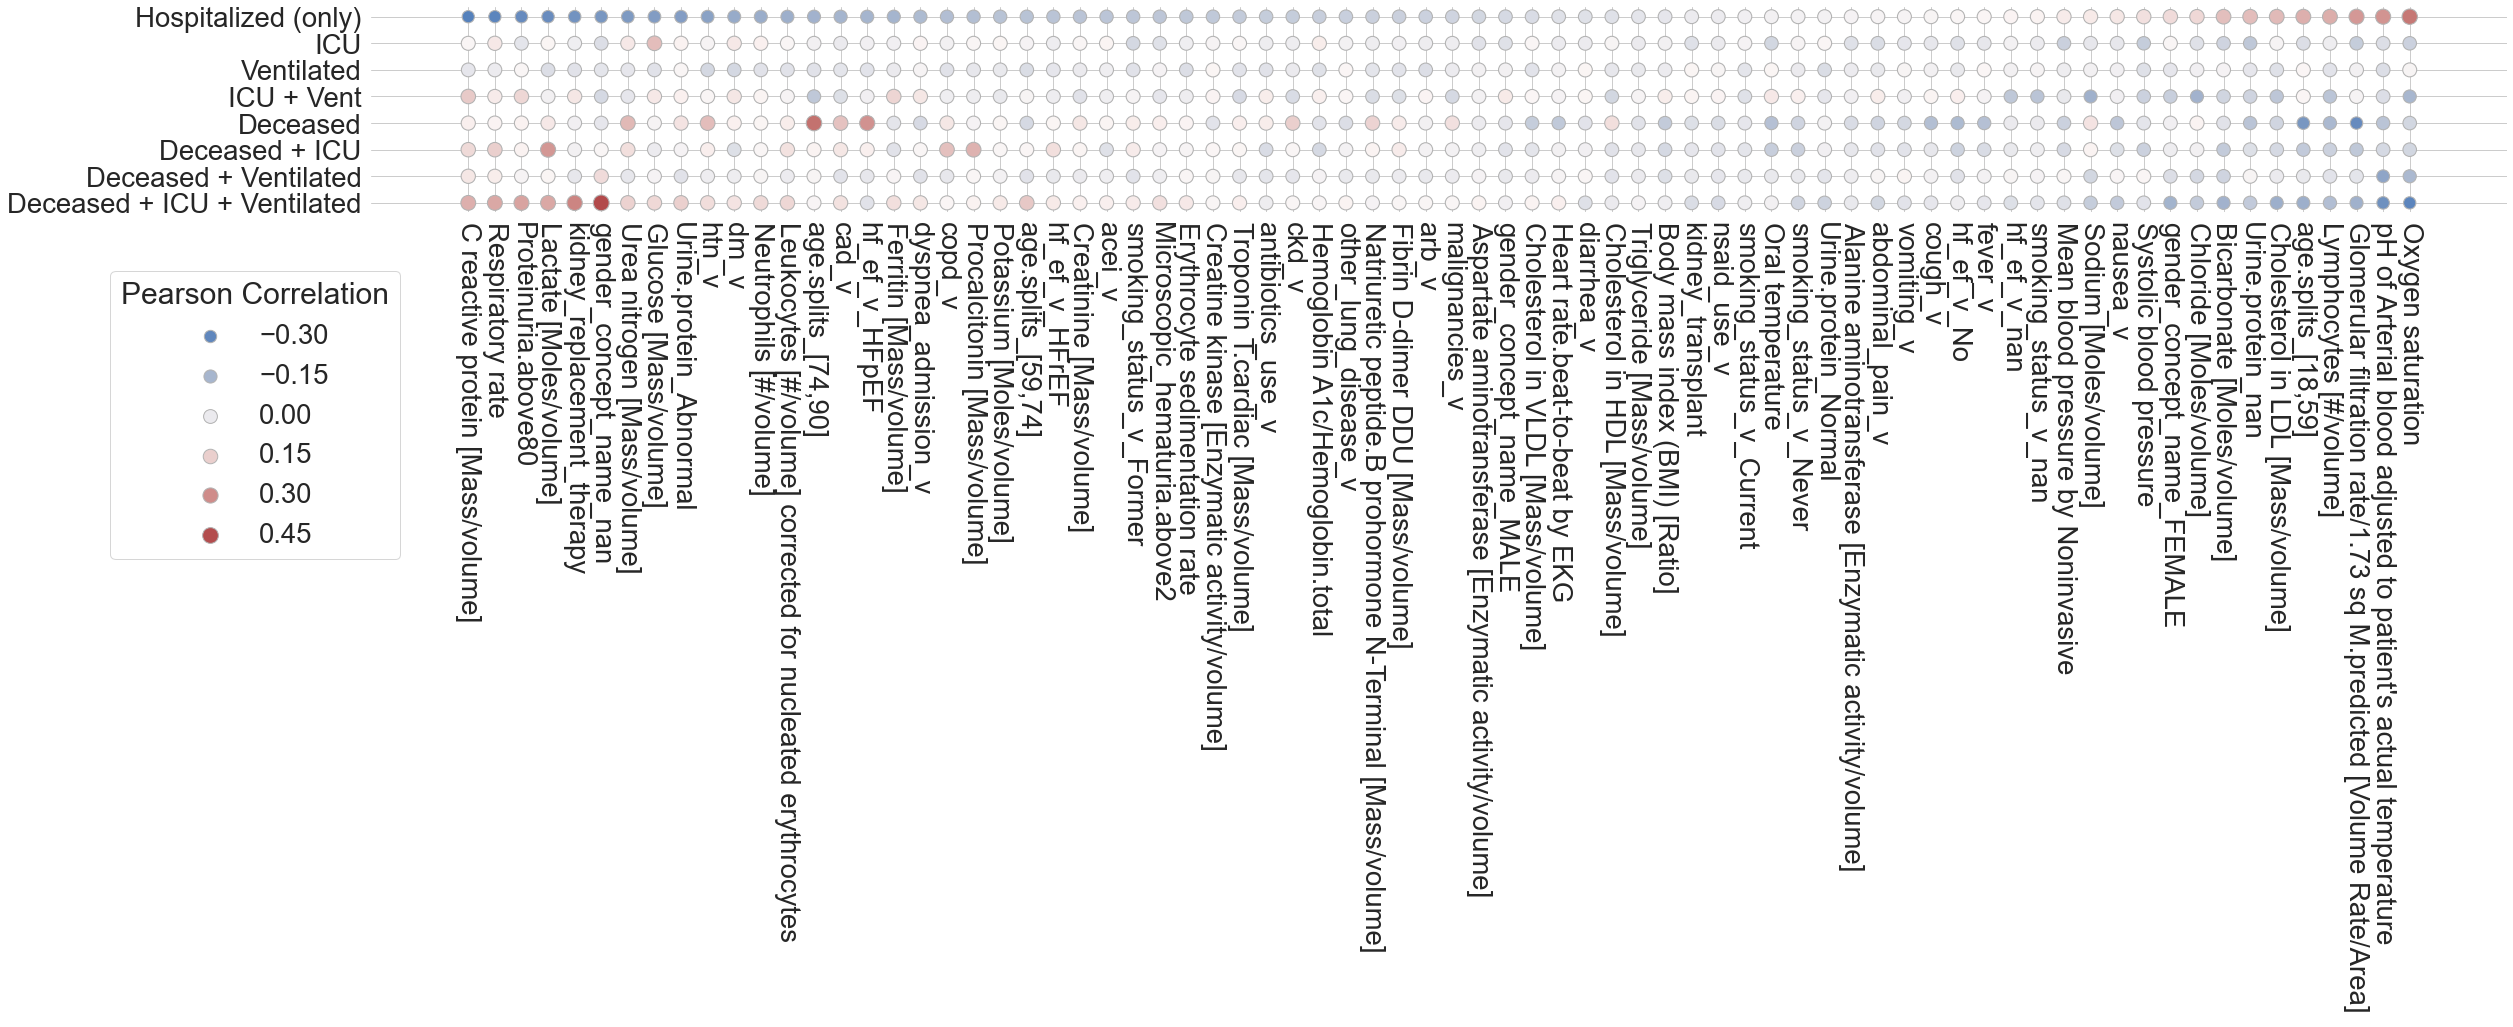

In [112]:
target_heatmap_ehds_ml = ehds_ml.copy()
target_heatmap_ehds_ml = target_heatmap_ehds_ml.reindex(sorted(target_heatmap_ehds_ml.columns, key=lambda v: v.lower()), axis=1)
target_heatmap_ehds_ml.columns = _newcols # from above...

shortticks = [c[-15:] for c in cdf.columns]

sns.set_theme(style="whitegrid", font_scale=2.5)

#plt.figure(figsize=(28,14))

g = sns.relplot(data=target_heatmap_ehds_ml.corr()[targets]\
                .drop(_drops + list(ld.ml_target_df["Outcome"].unique()), errors="ignore")\
                .sort_values(by="Hospitalized (only)", ascending=True)[_ordering]\
                .T.stack().reset_index(name="correlation"),
            y="level_0", x="level_1", hue="correlation", size="correlation",
            palette="vlag", hue_norm=(-.4, .5),
            edgecolor=".7",
            height=20, aspect=1.8,
            sizes=(150, 250), 
            )

# sns.heatmap(ehds_ml.rename(columns=_rn).corr()[targets]\
#             .iloc[:-8,:].drop(_drops).sort_values(by="Hospitalized (only)", ascending=True)[_ordering].T,
#     #square=True,
#     vmax=0.5, vmin=-0.5,
#     #annot=True,
#     #fmt=".1f",
#     linewidths=0.01, 
#     cmap="coolwarm",
#     cbar=True,
#     cbar_kws={"orientation": "horizontal", "location": "bottom",
#         "fraction": 0.01,# "aspect":20, #"shrink":0.08,
#         "anchor": (-0.0825, 0.125)
#         },
#     #yticklabels=shortticks[:-8]
# )
#plt.title("Radiomics Features correlation with prediction targets", size=16)
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
for label in g.ax.get_xticklabels():
    label.set_rotation(270)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
g.tight_layout()
leg = g._legend
leg.set_bbox_to_anchor([0.15, 0.425])
leg.set_frame_on(True)
leg.set_title("Pearson Correlation")
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.subplots_adjust(left=0, bottom=None, right=0, top=None, wspace=None, hspace=None)
#g.savefig("../thesis/figures/impl/corr_medical_features_relplot_180dpi.png", dpi=180)
#g.savefig("../thesis/figures/impl/corr_medical_features_relplot_320dpi.png", dpi=320)

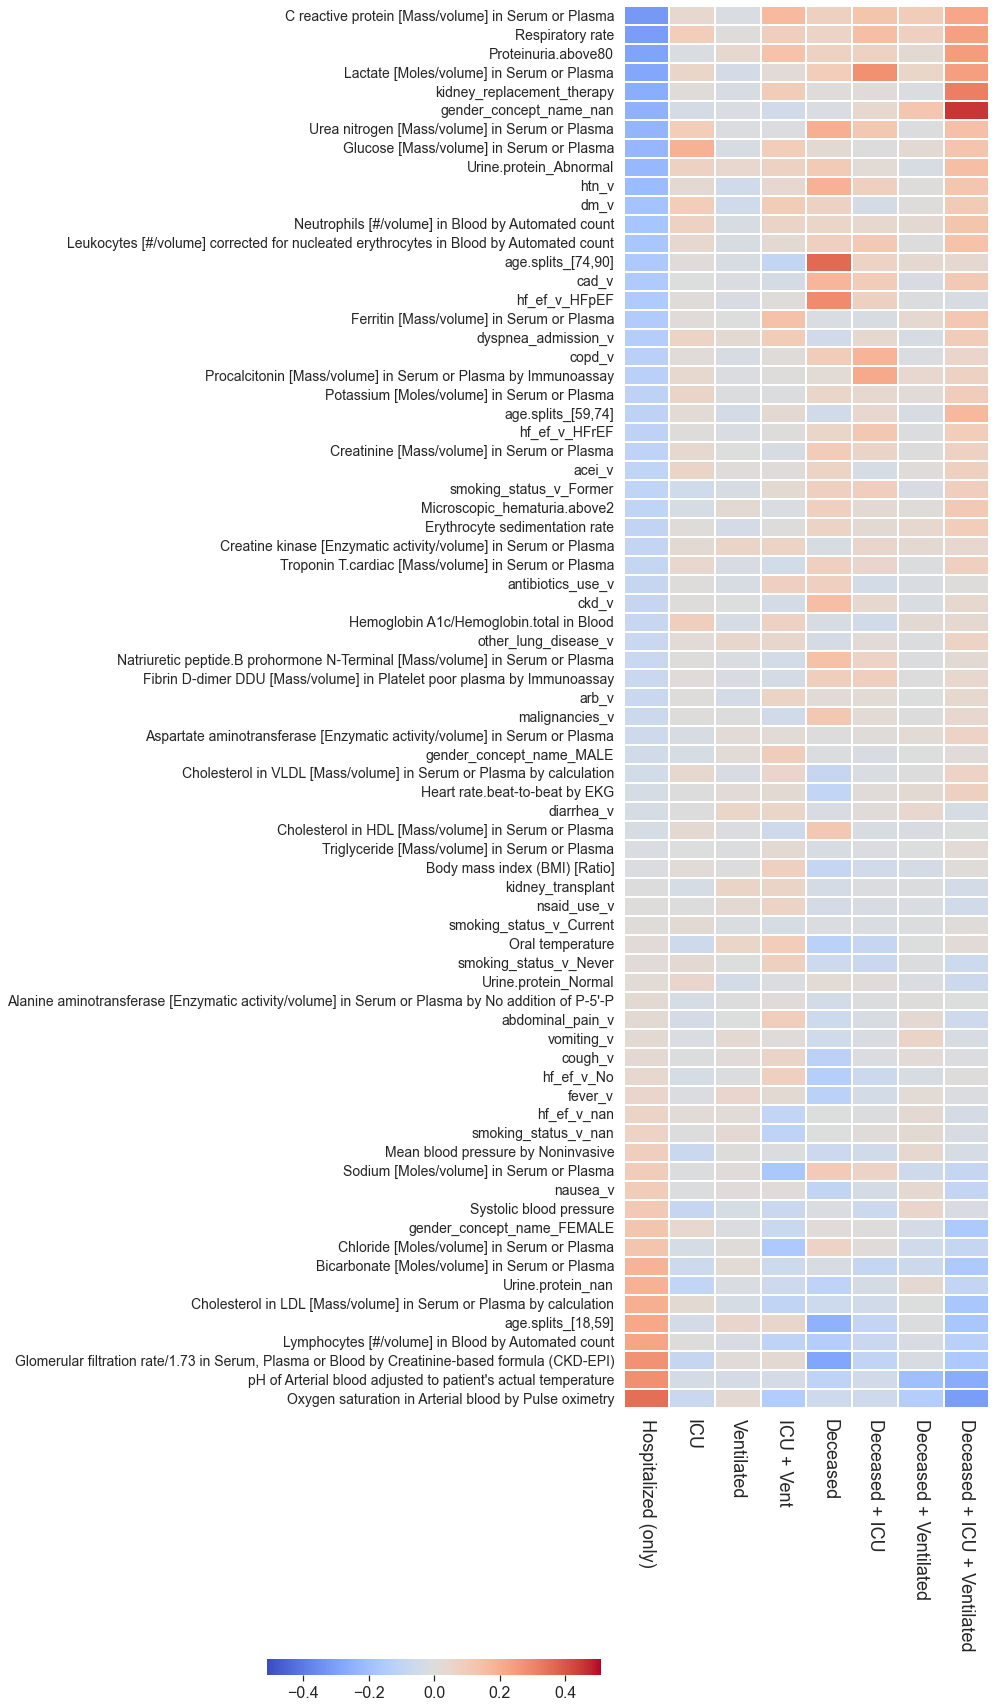

In [113]:
sns.set_theme(style="whitegrid", font_scale=1.)

cdf = ehds_ml.corr()
shortticks = [c[-15:] for c in cdf.columns]

_rn = "Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)"
_rnn = "Glomerular filtration rate/1.73 in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)"

plt.figure(figsize=(14,24))
sns.heatmap(ehds_ml.corr().rename(index={_rn: _rnn}
            )[targets].iloc[:-8,:].drop(_drops).sort_values(by="Hospitalized (only)", ascending=True)[_ordering],
    #square=True,
    vmax=0.51, vmin=-0.51,
    #annot=True,
    #fmt=".1f",
    linewidths=0.01, 
    cmap="coolwarm",
    cbar=True,
    cbar_kws={"orientation": "horizontal", "location": "bottom",
        "fraction": 0.01,# "aspect":20, #"shrink":0.08,
        #"anchor": (0.0, 0.0)
        },
    #yticklabels=shortticks[:-8]
)
#plt.title("Radiomics Features correlation with prediction targets", size=16)
plt.yticks(size=14)
plt.xticks(size=18, rotation=270)
plt.tight_layout()
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=16)
cax.set_anchor((-11.2, 25.25))


#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.subplots_adjust(left=0, bottom=None, right=0, top=None, wspace=None, hspace=None)
#plt.savefig("../thesis/figures/impl/corr_medical_features.png", dpi=180)

## Prediction

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve, roc_auc_score, mean_absolute_error, balanced_accuracy_score, f1_score, accuracy_score, make_scorer, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
#fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

from imblearn.pipeline import Pipeline as Pipeline_sampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

random_state = 42
rnd_state = random_state

In [115]:
corrdf = ehds_ml.corr()[targets]#.abs()
#print(corrdf[corrdf.abs()>0.5].dropna(thresh=1).round(3).fillna("-").drop(targets)[ld._targets].to_latex())
corrdf[corrdf.abs()>0.5].dropna(thresh=1).round(3).fillna("-").drop(targets)[ld._targets]

Empty DataFrame
Columns: [last.status, is_icu, was_ventilated]
Index: []

In [116]:
X = medical_df.copy()
y = ld.ml_target_df["y"].copy()

y[y==5] = 7
y.value_counts()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=random_state,
                                            stratify=y
                                            )
print(X_train.shape, X_val.shape)
X_train = ld.process_features(input_df=X_train, impute=False, return_df=True, normalize_dates=False)
X_val = ld.process_features(input_df=X_val, impute=False, return_df=True, encoder="reuse", normalize_dates=False)
print(X_train.shape, X_val.shape)

(959, 130) (320, 130)
(959, 77) (320, 77)


In [117]:
#to_drop = ["invasive_vent_days", "length_of_stay", "Acute.Kidney.Injury..during.hospitalization.", "Acute.Hepatic.Injury..during.hospitalization."]

X_train = X_train.drop(ld._targets, axis=1) # drop targets
#X_train = X_train.drop(to_drop, axis=1)

X_val = X_val.drop(ld._targets, axis=1) # drop targets
#X_val = X_val.drop(to_drop, axis=1)
print(X_train.shape, X_val.shape)

res = pd.DataFrame()

(959, 74) (320, 74)


In [118]:
y_train.value_counts()

0    711
7     76
3     75
4     46
2     35
6      8
1      8
Name: y, dtype: int64

In [119]:
from src.ehd_classification.prediction import classify, classify_imbalanced

_k = 8 # how many folds

In [120]:

## None
_res = classify(X_train, y_train, k_fold=_k)
_res["method"] = "None"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

## balanced-weights
_res = classify(X_train, y_train, class_weights="balanced", k_fold=_k)
_res["method"] = "Balanced-Weights"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:08:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:14] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:08:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:16] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:08:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:31] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:08:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:32] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Try Undersampling

In [121]:
## rus
_res = classify_imbalanced(X_train, y_train, sampler=RandomUnderSampler(random_state=rnd_state), k_fold=_k)
_res["method"] = "Random-Undersampling"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

## ros
_res = classify_imbalanced(X_train, y_train, sampler=RandomOverSampler(random_state=rnd_state), k_fold=_k)
_res["method"] = "Random-Oversampling"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

## SMOTE
_res = classify_imbalanced(X_train, y_train, sampler=SMOTE(random_state=rnd_state), k_fold=_k)
_res["method"] = "SMOTE"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res = pd.concat([res, _res])

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:09:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:00] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:09:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:02] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[15:09:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:24] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:09:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:09:28] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:09:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[15:10:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:09] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:10:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:15] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [122]:
res_table = res.filter(regex="mean_test").drop(('Balanced-Weights', 'xgboost')).round(2)
_metrics = ["Accuracy", "Balanced-Accuracy", "ROC-AUC", "Recall"] 
res_table.columns=_metrics
res_std_table = res.filter(regex="std_test").drop(('Balanced-Weights', 'xgboost')).round(2)
res_std_table.columns=_metrics
res_table_string = res_table[_metrics].astype(str) + "\n +/-" + res_std_table[_metrics].astype(str)
#res_table_string
#print(res_table_string.T.to_latex(caption="Test", label="tab:results"))

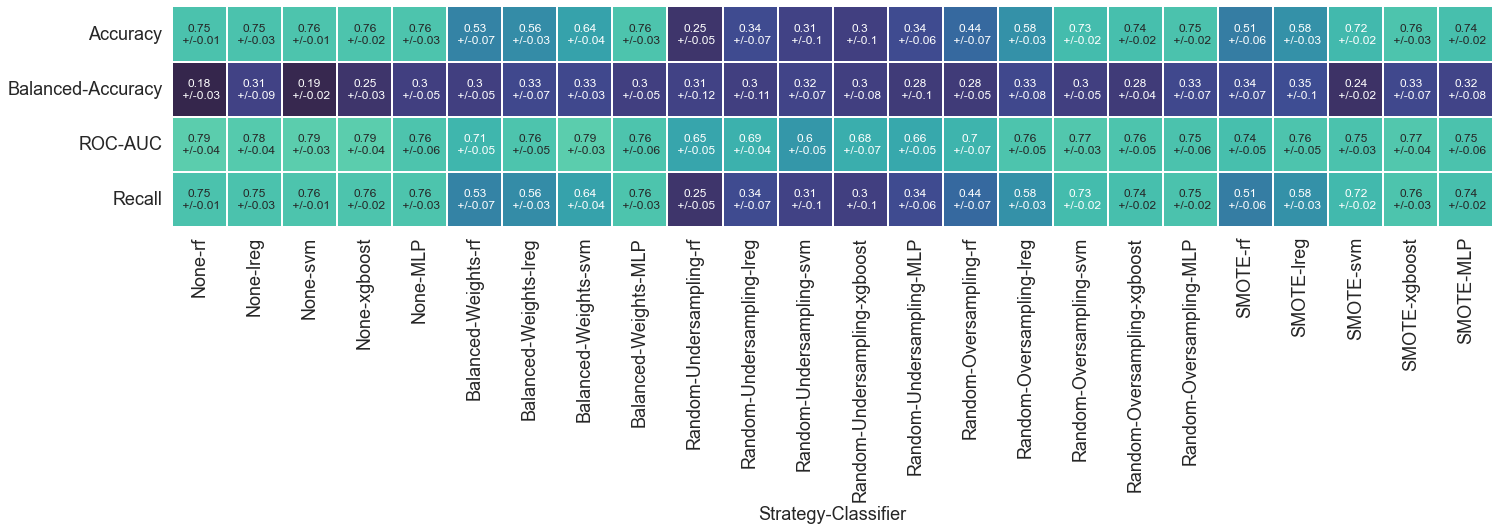

In [123]:
fig, ax = plt.subplots(1,1, figsize=(21,9), #sharex=True
)
fig.patch.set_facecolor('#ffffff')
#plt.figure(figsize=(21,9))
g = sns.heatmap(res_table.T, square=True, linewidth=0.05,
            cmap="mako", vmin=0.0, vmax=1.0,
            annot = res_table_string.T, fmt="", cbar=False
            # annot=True, fmt=".3f", cbar=False
            #cbar_kws={"orientation": "horizontal", "location": "bottom",
            #"fraction": 0.1, "aspect":5, "shrink":0.08,
            #"anchor": (0.1, 1.1)
            #},
        )

g.set(xlabel="", ylabel="", aspect="equal")
#g.despine(left=True, bottom=True)
g.set_xlabel("Strategy-Classifier", fontsize=18)
for label in g.get_yticklabels():
    label.set_fontsize(18)
for label in g.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(18)
fig.tight_layout()
#print(res.T.to_latex())
#fig.savefig("../thesis/figures/results/ehd.png", dpi=180)

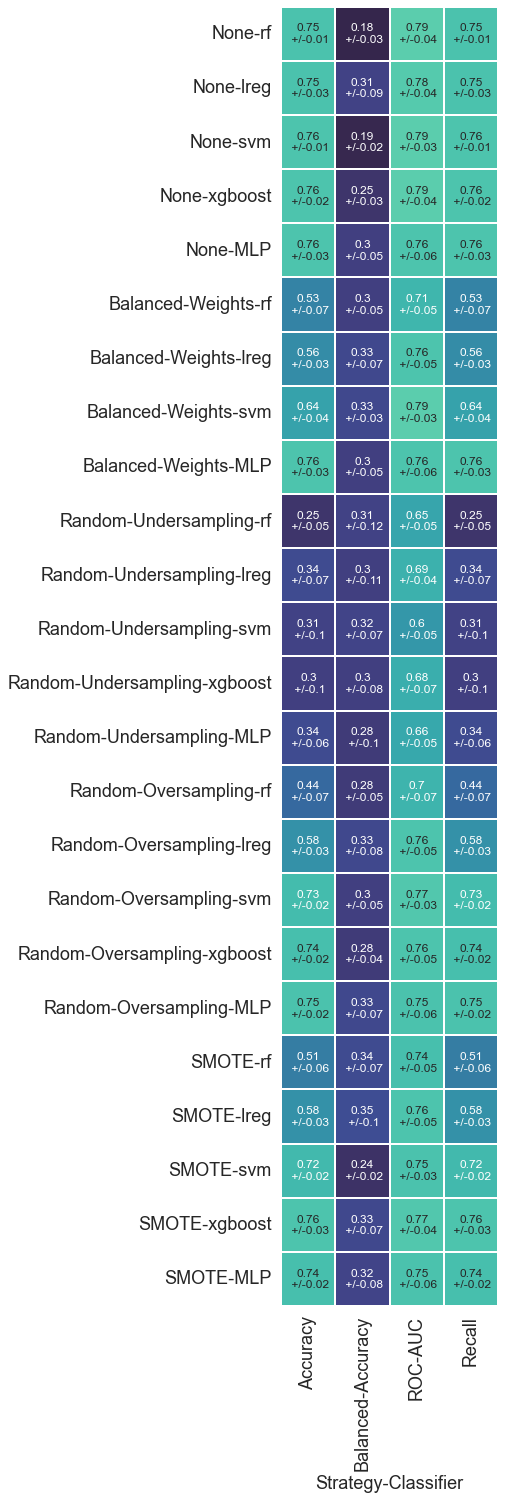

In [124]:
fig, ax = plt.subplots(1,1, figsize=(9,21), #sharex=True
)
fig.patch.set_facecolor('#ffffff')
#plt.figure(figsize=(21,9))
g = sns.heatmap(res_table, square=True, linewidth=0.05,
            cmap="mako", vmin=0.0, vmax=1.0,
            annot = res_table_string, fmt="", cbar=False
            # annot=True, fmt=".3f", cbar=False
            #cbar_kws={"orientation": "horizontal", "location": "bottom",
            #"fraction": 0.1, "aspect":5, "shrink":0.08,
            #"anchor": (0.1, 1.1)
            #},
        )

g.set(xlabel="", ylabel="", aspect="equal")
#g.despine(left=True, bottom=True)
g.set_xlabel("Strategy-Classifier", fontsize=18)
for label in g.get_yticklabels():
    label.set_fontsize(18)
for label in g.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(18)
fig.tight_layout()
#print(res.T.to_latex())
#fig.savefig("../thesis/figures/results/ehd.png", dpi=180)

We can see that we get an ok-ish ROC_AUC score for multiple classifiers. Best would be probably SVM with balanced weights or SMOTE+xgbost

In general, a high ROC_AUC is a good in-between metric. A "higher" balanced-accuracy score would indicate that we are most likely possible to get the classifier to predict the underrepresented classes. This is especially true when we also look at the recall score, that might be lower in that case, which would indiciate a less good performance on the majority class. 
For instance, see SVM-balanced weights and svm without - they have a comparable ROC_AUC but they differ quite in bal-acc and recall+accuracy, as those metrics score better when the majority class got predicted better.

### Try with PCA

In [125]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

res_pca = pd.DataFrame()

_res = classify(X_train, y_train, pca=True, k_fold=_k)
_res["method"] = "None"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res_pca = pd.concat([res_pca, _res])


_res = classify(X_train, y_train, class_weights="balanced", pca=True, k_fold=_k)
_res["method"] = "Balanced-Weights"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res_pca = pd.concat([res_pca, _res])

## rus
_res = classify_imbalanced(X_train, y_train, sampler=RandomUnderSampler(random_state=rnd_state), pca=True, k_fold=_k)
_res["method"] = "Random-Undersampling"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res_pca = pd.concat([res_pca, _res])

_res = classify_imbalanced(X_train, y_train, sampler=RandomOverSampler(random_state=rnd_state), pca=True, k_fold=_k)
_res["method"] = "Random-Oversampling"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res_pca = pd.concat([res_pca, _res])

_res = classify_imbalanced(X_train, y_train, sampler=SMOTE(random_state=random_state), pca=True, k_fold=_k)
_res["method"] = "SMOTE"
_res.reset_index(inplace=True)
_res.set_index(["method", "index"], inplace=True)
res_pca = pd.concat([res_pca, _res])

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:10:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:45] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:10:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:10:47] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:11:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:05] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:11:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:07] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:11:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:22] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:11:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:22] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[15:11:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:41] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:11:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:44] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:11:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[15:12:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:12:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:12:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:12:19] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ostritze/opt/anacon

[15:12:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:12:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:12:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:12:25] WARNING: /Users/runner/miniforge3/c

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


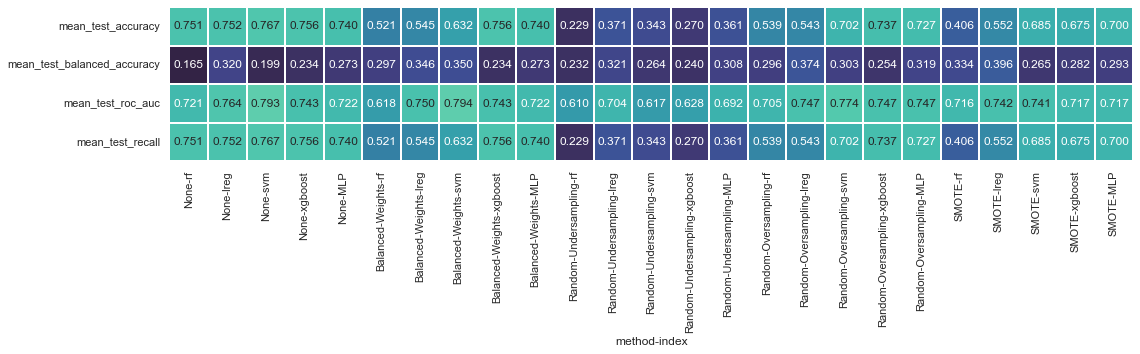

In [126]:
fig, ax = plt.subplots(1,1, figsize=(16,10), sharex=True)
fig.patch.set_facecolor('#ffffff')
#plt.figure(figsize=(21,9))
sns.heatmap(res_pca.filter(regex="mean_test").T, square=True, linewidth=0.05,
            cmap="mako", vmin=0.0, vmax=1.0, annot=True, fmt=".3f", cbar=False
            #cbar_kws={"orientation": "horizontal", "location": "bottom",
            #"fraction": 0.1, "aspect":5, "shrink":0.08,
            #"anchor": (0.1, 1.1)
            #},
        )
fig.tight_layout()
#print(res.T.to_latex())

In [127]:
res_table_pca = res_pca.filter(regex="mean_test").drop(('Balanced-Weights', 'xgboost')).round(2)
res_table_pca.columns=_metrics
res_std_table_pca = res_pca.filter(regex="std_test").drop(('Balanced-Weights', 'xgboost')).round(2)
res_std_table_pca.columns=_metrics
res_table_string_pca = res_table_pca[_metrics].astype(str) + "\n +/-" + res_std_table_pca[_metrics].astype(str)
#res_table_string
#print(res_table_string.T.to_latex(caption="Test", label="tab:results"))

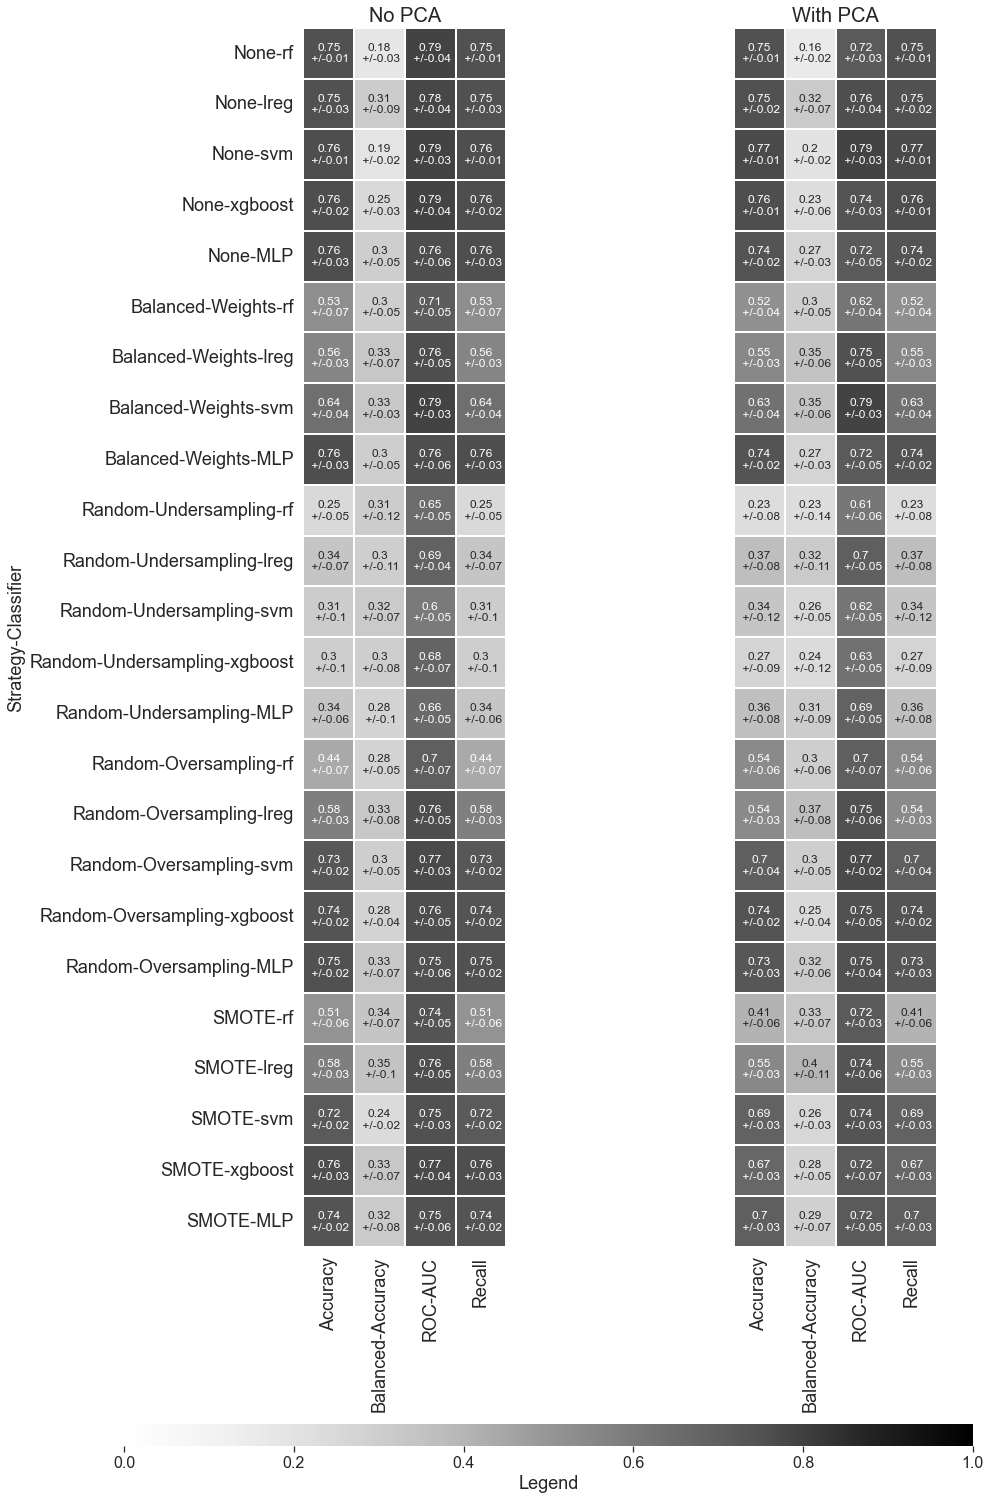

In [160]:
#fig, ax = plt.subplots(1,2, figsize=(14, 21), sharey=True)
fig = plt.figure(figsize=(14,21))
ax0 = plt.subplot2grid((8, 6), (0, 0), rowspan=7, colspan=4)
ax1 = plt.subplot2grid((8, 6), (0, 4), rowspan=7, colspan=2)
ax2 = plt.subplot2grid((8, 6), (7, 0), rowspan=1, colspan=6)

fig.patch.set_facecolor('#ffffff')
#plt.figure(figsize=(21,9))
g = sns.heatmap(res_table, square=True, linewidth=0.05,
            cmap="Greys",
            vmin=0.0, vmax=1.0,
            ax=ax0,
            annot = res_table_string, fmt="", cbar=True,
            # annot=True, fmt=".3f", cbar=False
            cbar_kws={"orientation": "horizontal", "label":"Legend"
            # "location": "bottom",
            #"fraction": 0.1, "aspect":5,
            #"shrink":0.05,
            #"anchor": (0.1, 1.1)
            },
            cbar_ax=ax2,
        )

g.set_title("No PCA", fontsize=20)
g.set(xlabel="", ylabel="", aspect="equal")
#g.despine(left=True, bottom=True)
g.set_ylabel("Strategy-Classifier", fontsize=18)
for label in g.get_yticklabels():
    label.set_fontsize(18)
for label in g.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(18)

f = sns.heatmap(res_table_pca, square=True, linewidth=0.05,
            cmap="Greys", vmin=0.0, vmax=1.0,
            annot = res_table_string_pca, fmt="", cbar=False,
            # annot=True, fmt=".3f", 
            #cbar=True,
            #cbar_kws={"orientation": "horizontal",},# "location": "bottom",
            #"fraction": 0.1, "aspect":5, "shrink":0.08,
            #"anchor": (0.1, 1.1)
            #        },
            ax=ax1
        )
f.set_title("With PCA", fontsize=20)
f.set(xlabel="", ylabel="", aspect="equal")
f.set_yticklabels([])
#g.despine(left=True, bottom=True)
#f.set_ylabel("Strategy-Classifier", fontsize=18)
for label in f.get_yticklabels():
    label.set_fontsize(18)
for label in f.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(18)

ax2.set_frame_on(True)
ax2.tick_params(labelsize=16)
ax2.xaxis.label.set_size(18)

fig.tight_layout()
#print(res.T.to_latex())

fig.savefig("../thesis/figures/results/ehd_pca.png")#, dpi=180)

In [ ]:
# clfs = [('rf', RandomForestClassifier(n_estimators=10, max_depth=5,
#                 random_state=rnd_state, class_weight="balanced")),
#             ('lreg', LogisticRegression(random_state=rnd_state, max_iter=250,
#                 class_weight="balanced")),
#             ("xgboost", XGBClassifier(n_jobs=4, n_estimators=20, random_state=rnd_state)),
#             ('MLP', MLPClassifier(solver="adam", learning_rate="adaptive",
#                     random_state=rnd_state, max_iter=500, #class_weight=class_weights
#                     )),
#             ]
# param_grid = {}

# #fig, ax = plt.subplots(2, len(clfs), figsize=(20, 8))
# #fig.patch.set_facecolor('#ffffff')
# res = pd.DataFrame()

# scoring = { 'accuracy': make_scorer(accuracy_score),
#         'balanced_accuracy': make_scorer(balanced_accuracy_score),
#         'f1_weighted': make_scorer(f1_score, average = 'weighted'),
#         'roc_auc': make_scorer(roc_auc_score, multi_class=solver, needs_proba=True, average="weighted"),
#         'recall': make_scorer(recall_score, average = 'weighted'),
#     }

# pipe = Pipeline([('scaler', StandardScaler()),
#                 ('imp', KNNImputer()),
#                 ('scaler2', StandardScaler()),
#                 #('pca', PCA(n_components=0.95)),
#                 ('svm', SVC(probability=True, class_weight="balanced", random_state=rnd_state))])

# gscv = GridSearchCV(pipe, param_grid, scoring=scoring, n_jobs=4, cv=_k, refit="roc_auc")
# gscv.fit(X_train, y_train)

# ConfusionMatrixDisplay.from_estimator(gscv.best_estimator_, X_train, y_train, ax=ax[0])
# ax[0, i].set_title(f"{c[0]}")

### Try with Iterative Imputer

In [413]:
# from sklearn.experimental import enable_iterative_imputer  # noqa
# from sklearn.impute import IterativeImputer

# res_iterative = pd.DataFrame()

# _res = classify(X_train, y_train, class_weights="balanced", imputer=IterativeImputer(random_state=random_state, max_iter=100))
# _res["method"] = "balanced-weights"
# _res.reset_index(inplace=True)
# _res.set_index(["method", "index"], inplace=True)
# res_iterative = pd.concat([res_iterative, _res])

# _res = classify_imbalanced(X_train, y_train, sampler=RandomOverSampler(random_state=rnd_state), imputer=IterativeImputer(random_state=random_state, max_iter=100))
# _res["method"] = "random-oversampling"
# _res.reset_index(inplace=True)
# _res.set_index(["method", "index"], inplace=True)
# res_pca = pd.concat([res_iterative, _res])


# _res = classify_imbalanced(X_train, y_train, sampler=SMOTE(random_state=random_state), imputer=IterativeImputer(random_state=random_state, max_iter=100))
# _res["method"] = "SMOTE"
# _res.reset_index(inplace=True)
# _res.set_index(["method", "index"], inplace=True)
# res_iterative = pd.concat([res_iterative, _res])

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[14:36:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

[14:41:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


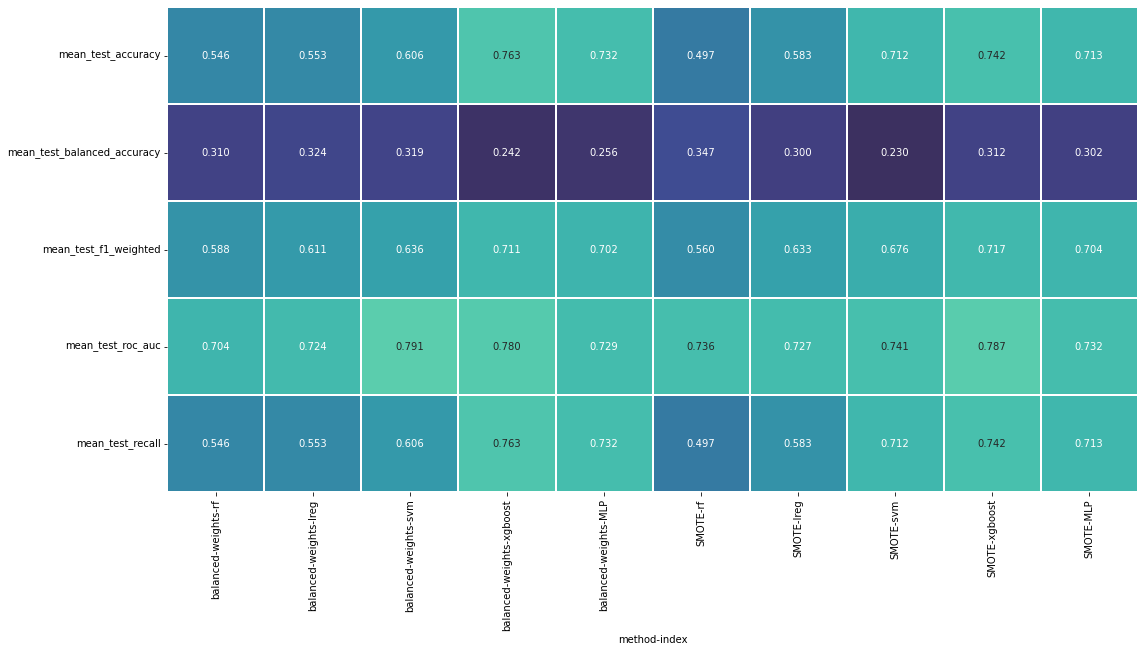

In [414]:
# fig, ax = plt.subplots(1,1, figsize=(16,10), sharex=True)
# fig.patch.set_facecolor('#ffffff')
# #plt.figure(figsize=(21,9))
# sns.heatmap(res_iterative.filter(regex="mean_test").T, square=True, linewidth=0.05,
#             cmap="mako", vmin=0.0, vmax=1.0, annot=True, fmt=".3f", cbar=False
#             #cbar_kws={"orientation": "horizontal", "location": "bottom",
#             #"fraction": 0.1, "aspect":5, "shrink":0.08,
#             #"anchor": (0.1, 1.1)
#             #},
#         )
# fig.tight_layout()
# #print(res.T.to_latex())

## CV

In [23]:
X_full = ld.process_features(input_df=X, impute=False, return_df=True, normalize_dates=False)
X_full = X_full.drop(ld._targets, axis=1)

In [24]:
X_train.shape

(959, 74)

In [47]:
REFITs = ["accuracy", "balanced_accuracy", "recall", "roc_auc"]
# smote+xg

results = pd.DataFrame()

for REFIT in REFITs:
    print(REFIT)
    pipe_svm = Pipeline_sampler([("sc", StandardScaler()),
                    ('imp', KNNImputer()),
                    ("sc2", StandardScaler()),
                    ("svc", SVC(probability=True, class_weight="balanced")),
                    ])

    p_svm = {
        "svc__random_state" : [0, 42, 420, 64532],
        "svc__class_weight" : ["balanced"],
        "svc__C" : [0.01, 0.1, 0.25, 0.5, 0.75,
                    1, 1.5, 3, 5, 10,
                    15, 25, 30],
        "svc__kernel": ["rbf", "poly", "linear"],
        "svc__decision_function_shape": ["ovo"],
    }

    scoring = { 'accuracy': make_scorer(accuracy_score),
                'balanced_accuracy': make_scorer(balanced_accuracy_score),
                'f1_weighted': make_scorer(f1_score, average = 'weighted'),
                'roc_auc': make_scorer(roc_auc_score, multi_class="ovo", needs_proba=True, average="weighted"),
                'recall': make_scorer(recall_score, average = 'weighted'),
            }

    gscv = GridSearchCV(pipe_svm, p_svm,
        scoring=scoring, cv=_k, n_jobs=4, refit=REFIT)
    gscv.fit(X_train, y_train)
    gsres = pd.DataFrame(gscv.cv_results_)

    best_model = gscv.best_estimator_
    print(best_model)

    _roc = gsres.sort_values(by=["mean_test_roc_auc", "mean_test_balanced_accuracy"], ascending=False).round(3).iloc[0,:]["mean_test_roc_auc"]
    _roc_std = gsres.sort_values(by=["mean_test_roc_auc", "mean_test_balanced_accuracy"], ascending=False).round(3).iloc[0,:]["std_test_roc_auc"]
    print("cv-train {}: {} +/- {:.3f}".format(REFIT, _roc, _roc_std*1.96))

    if not os.path.isfile(f"models/ehd/svm_{REFIT}.pkl"):
        joblib.dump(best_model, f"models/ehd/svm_{REFIT}.pkl")
        joblib.dump(best_model.fit(X_full,y), f"models/ehd/svm_{REFIT}_trained_on_all.pkl")
    else:
        best_model = joblib.load(f"models/ehd/svm_{REFIT}.pkl")



accuracy
Pipeline(steps=[('sc', StandardScaler()), ('imp', KNNImputer()),
                ('sc2', StandardScaler()),
                ('svc',
                 SVC(C=25, class_weight='balanced',
                     decision_function_shape='ovo', probability=True,
                     random_state=0))])
cv-train accuracy: 0.795 +/- 0.063
balanced_accuracy
Pipeline(steps=[('sc', StandardScaler()), ('imp', KNNImputer()),
                ('sc2', StandardScaler()),
                ('svc',
                 SVC(C=0.01, class_weight='balanced',
                     decision_function_shape='ovo', kernel='linear',
                     probability=True, random_state=0))])
cv-train balanced_accuracy: 0.795 +/- 0.063
recall
Pipeline(steps=[('sc', StandardScaler()), ('imp', KNNImputer()),
                ('sc2', StandardScaler()),
                ('svc',
                 SVC(C=25, class_weight='balanced',
                     decision_function_shape='ovo', probability=True,
                     rando

## Eval

In [38]:
from src.ehd_classification.prediction import compute_metrics
REFITs = ["accuracy", "balanced_accuracy", "recall", "roc_auc"]

final_results = pd.DataFrame()
cms = []
for REFIT in REFITs:
    print(f"{REFIT}:    ")
    model = joblib.load(f"models/ehd/svm_{REFIT}.pkl")
    
    r1, r2, cm = compute_metrics(model, X_train, y_train, X_val, y_val, index=REFIT)
    cms.append(cm)
    final_results = final_results.append(r1)
    print(r2)
    if REFIT == "balanced_accuracy":
        print(r2.T.to_latex(label="tab:results_best"))
    print("")
final_results

accuracy:    
                              0    1      2      3      4    6      7
TPR-Sensitivity (recall)  0.975  0.0  0.000  0.040  0.067  0.0  0.423
TNR-Specificity           0.265  1.0  0.994  0.976  0.997  1.0  0.983

balanced_accuracy:    
                              0      1      2      3      4      6      7
TPR-Sensitivity (recall)  0.608  0.333  0.273  0.240  0.600  0.000  0.577
TNR-Specificity           0.795  0.927  0.903  0.936  0.905  0.991  0.929
\begin{table}
\centering
\label{tab:results_best}
\begin{tabular}{lrr}
\toprule
{} &  TPR-Sensitivity (recall) &  TNR-Specificity \\
\midrule
0 &                     0.608 &            0.795 \\
1 &                     0.333 &            0.927 \\
2 &                     0.273 &            0.903 \\
3 &                     0.240 &            0.936 \\
4 &                     0.600 &            0.905 \\
6 &                     0.000 &            0.991 \\
7 &                     0.577 &            0.929 \\
\bottomrule
\end{tabular

F1  Accuracy  Balanced Accuracy  Recall  ROC-AUC
accuracy           0.700     0.762              0.215   0.762    0.793
balanced_accuracy  0.615     0.556              0.376   0.556    0.790
recall             0.700     0.762              0.215   0.762    0.793
roc_auc            0.672     0.644              0.364   0.644    0.780

In [30]:
#acc
cms[0]

0  1  2  3  4  6   7
0  231  0  1  2  1  0   2
1    3  0  0  0  0  0   0
2   10  0  0  1  0  0   0
3   24  0  0  1  0  0   0
4   12  0  0  0  1  0   2
6    1  0  1  0  0  0   1
7   11  0  0  4  0  0  11

In [59]:
# balanced-acc
_cm = cms[1]
_cm.columns = ['',
        '', '', '',
        '', '',
        '']
_cm.columns =['Hospitalized',
        'Vent', 'ICU', 'ICU + Vent.',
        'Deceased', 'Deceased + ICU',
        'Deceased + ICU + Vent.']
_cm.index = ['Hospitalized',
        'Vent', 'ICU', 'ICU + Vent.',
        'Deceased', 'Deceased + ICU',
        'Deceased + ICU + Vent.']
_cm.to_markdown()

'|                        |   Hospitalized |   Vent |   ICU |   ICU + Vent. |   Deceased |   Deceased + ICU |   Deceased + ICU + Vent. |\n|:-----------------------|---------------:|-------:|------:|--------------:|-----------:|-----------------:|-------------------------:|\n| Hospitalized           |            144 |     21 |    20 |            15 |         21 |                2 |                       14 |\n| Vent                   |              1 |      1 |     0 |             0 |          0 |                0 |                        1 |\n| ICU                    |              5 |      0 |     3 |             0 |          3 |                0 |                        0 |\n| ICU + Vent.            |              9 |      2 |     4 |             6 |          2 |                0 |                        2 |\n| Deceased               |              1 |      0 |     1 |             0 |          9 |                0 |                        4 |\n| Deceased + ICU         |              

In [42]:
# recall / Sensitivity TPR
_cm = cms[2]

_cm.columns = ['Hospitalized',
        'Vent', 'ICU', 'ICU + Vent.',
        'Deceased', 'Deceased + ICU',
        'Deceased + ICU + Vent.']
_cm.index = ['Hospitalized',
        'Vent', 'ICU', 'ICU + Vent.',
        'Deceased', 'Deceased + ICU',
        'Deceased + ICU + Vent.']
_cm

Hospitalized  Vent  ICU  ICU + Vent.  Deceased  \
Hospitalized                     231     0    1            2         1   
Vent                               3     0    0            0         0   
ICU                               10     0    0            1         0   
ICU + Vent.                       24     0    0            1         0   
Deceased                          12     0    0            0         1   
Deceased + ICU                     1     0    1            0         0   
Deceased + ICU + Vent.            11     0    0            4         0   

                        Deceased + ICU  Deceased + ICU + Vent.  
Hospitalized                         0                       2  
Vent                                 0                       0  
ICU                                  0                       0  
ICU + Vent.                          0                       0  
Deceased                             0                       2  
Deceased + ICU                       0                       1  
Deceased + ICU + Vent.               0                      11

In [28]:
# ROC-AUC
cms[3]

0  1  2   3   4  6   7
0  167  0  4  24  20  0  22
1    3  0  0   0   0  0   0
2    4  0  2   0   4  0   1
3    9  0  1   8   3  0   4
4    1  0  0   0   8  0   6
6    0  0  1   0   0  0   2
7    0  0  1   2   2  0  21

In [62]:
y_val.value_counts()

0    237
7     26
3     25
4     15
2     11
1      3
6      3
Name: y, dtype: int64